# Counting labels & weighted loss function

As you saw in the lecture videos, one way to avoid having class imbalance impact the loss function is to weight the losses differently. To choose the weights, you first need to calculate the class frequencies.

For this exercise, you'll just get the count of each label. Later on, you'll use the concepts practiced here to calculate frequencies in the assignment!

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read csv file
train_df = pd.read_csv('data/train-small.csv')
train_df.head(3)

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0


In [3]:
# count up the number of instances of each class
class_count = train_df.sum().drop(['Image', 'PatientId'])
class_count

Atelectasis           106
Cardiomegaly           20
Consolidation          33
Edema                  16
Effusion              128
Emphysema              13
Fibrosis               14
Hernia                  2
Infiltration          175
Mass                   45
Nodule                 54
Pleural_Thickening     21
Pneumonia              10
Pneumothorax           38
dtype: object

In [4]:
for col in class_count.keys():
    print(f'Class {col} has {train_df[col].sum()} samples')

Class Atelectasis has 106 samples
Class Cardiomegaly has 20 samples
Class Consolidation has 33 samples
Class Edema has 16 samples
Class Effusion has 128 samples
Class Emphysema has 13 samples
Class Fibrosis has 14 samples
Class Hernia has 2 samples
Class Infiltration has 175 samples
Class Mass has 45 samples
Class Nodule has 54 samples
Class Pleural_Thickening has 21 samples
Class Pneumonia has 10 samples
Class Pneumothorax has 38 samples


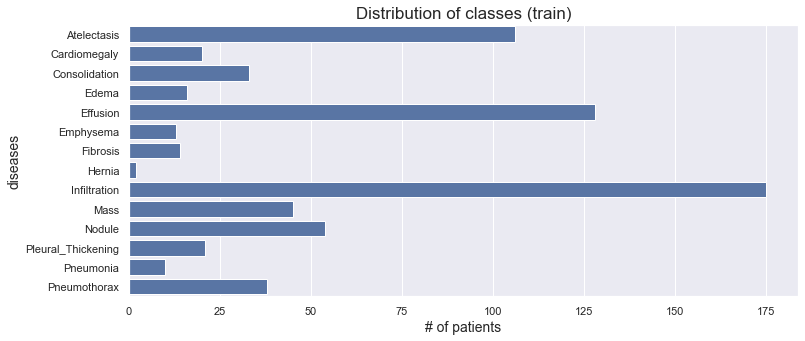

In [8]:
# plot count distribution
plt.figure(figsize=(12, 5))
sns.barplot(class_count.values, class_count.index, color='b')
plt.title('Distribution of classes (train)', size=17)
plt.xlabel('# of patients', size=14)
plt.ylabel('diseases', size=14)
plt.show()

### Weighted loss function

Below is an example of calculating weighted loss. In the assignment, you will calculate a weighted loss function. This sample code will give you some intuition for what the weighted loss function is doing, and also help you practice some syntax you will use in the graded assignment.

For this example, you'll first define a hypothetical set of true labels and then a set of predictions.

Run the next cell to create the 'ground truth' labels.

In [9]:
# Generate an array of 4 binary label values, 3 positive and 1 negative
y_true = np.array(
        [[1],
         [1],
         [1],
         [0]])
print(f"y_true: \n{y_true}")

y_true: 
[[1]
 [1]
 [1]
 [0]]


### 1.1 Understanding Weighted Loss Function

#### 1.1.1 Two Models

To better understand the loss function, you will pretend that you have two models.
- Model 1 always outputs a 0.9 for any example that it's given.
- Model 2 always outputs a 0.1 for any example that it's given.

In [10]:
# Make model predictions that are always 0.9 for all examples
y_pred_1 = 0.9 * np.ones(y_true.shape)
print(f"y_pred_1: \n{y_pred_1}")
print()
y_pred_2 = 0.1 * np.ones(y_true.shape)
print(f"y_pred_2: \n{y_pred_2}")

y_pred_1: 
[[0.9]
 [0.9]
 [0.9]
 [0.9]]

y_pred_2: 
[[0.1]
 [0.1]
 [0.1]
 [0.1]]


### 1.2 Problems with the Regular Loss Function
The learning goal here is to notice that with a regular loss function (not a weighted loss), the model that always outputs 0.9 has a smaller loss (performs better) than model 2.
- This is because there is a class imbalance, where 3 out of the 4 labels are 1.
- If the data were perfectly balanced, (two labels were 1, and two labels were 0), model 1 and model 2 would have the same loss.  Each would get two examples correct and two examples incorrect.
- However, since the data is not balanced, the regular loss function implies that model 1 is better than model 2.

#### 1.2.1 Shortcomings of regular non-weighted loss

See what loss you get from these two models (model 1 always predicts 0.9, and model 2 0.1). See what regular (unweighted) loss function is for each model

In [13]:
loss_reg_1 = -1 * np.sum(y_true * np.log(y_pred_1)) + -1 * np.sum((1 - y_true) * np.log(1 - y_pred_1))
print(f'Loss for model 1: {loss_reg_1:.4f}')

Loss for model 1: 2.6187


In [14]:
loss_reg_2 = -1 * np.sum(y_true * np.log(y_pred_2)) + -1 * np.sum((1 - y_true) * np.log(1 - y_pred_2))
print(f'Loss for model 2: {loss_reg_2:.4f}')

Loss for model 2: 7.0131


Notice that the loss function gives a greater loss when the predictions are always 0.1, because the data is imbalanced, and has three labels of 1 but only one label for 0.

Given a class imbalance with more positive labels, the regular loss function implies that the model with the higher prediction of 0.9 performs better than the model with the lower prediction of 0.1

### 1.3 Treatment by a Weighted Loss on the Two Models
With a weighted loss function, you will get the same weighted loss when the predictions are all 0.9 versus when the predictions are all 0.1.
- Notice how a prediction of 0.9 is 0.1 away from the positive label of 1.
- Also notice how a prediction of 0.1 is 0.1 away from the negative label of 0
- So model 1 and 2 are "symmetric" along the midpoint of 0.5, if you plot them on a number line between 0 and 1.

#### 1.3.1 Weighted Loss Equation
Calculate the loss for the zero-th label (column at index 0)

- The loss is made up of two terms.  To make it easier to read the code, you will calculate each of these terms separately.  We are giving each of these two terms a name for explanatory purposes, but these are not officially called $loss_{pos}$ or $loss_{neg}$

    - $loss_{pos}$: we'll use this to refer to the loss where the actual label is positive (the positive examples).
    - $loss_{neg}$: we'll use this to refer to the loss where the actual label is negative (the negative examples).

$$ loss^{(i)} = loss_{pos}^{(i)} + los_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$


Since this sample dataset is small enough, you can calculate the positive weight to be used in the weighted loss function. To get the positive weight, count how many NEGATIVE labels are present, divided by the total number of examples.

In this case, there is one negative label, and four total examples.

Similarly, the negative weight is the fraction of positive labels.

Run the next cell to define positive and negative weights.

In [15]:
# calculate the positive weight as the fraction of negative labels
w_p = 1 / 4

# calculate the negative weight as the fraction of positive labels
w_n = 3 / 4

print(f'positive weight w_p: {w_p}')
print(f'negative weight w_n: {w_n}')

positive weight w_p: 0.25
negative weight w_n: 0.75


#### 1.3.2 Weighted Loss: Model 1

Run the next two cells to calculate the two loss terms separately.

Here, `loss_1_pos` and `loss_1_neg` are calculated using the `y_pred_1` predictions.

In [24]:
# calculate and print two cells to calculate the two loss terms separately
loss_1_pos = -1 * np.sum(w_p * y_true * np.log(y_pred_1))
print(f'Loss pos: {loss_1_pos:.4f}')

Loss pos: 0.0790


In [26]:
loss_1_neg = -1 * np.sum(w_n * (1 - y_true) * np.log(1 - y_pred_1))
print(f'Loss neg: {loss_1_neg:.4f}')

Loss neg: 1.7269


In [28]:
loss_total_1 = loss_1_pos + loss_1_neg
print(f'Weighted Loss for model1: {loss_total_1:.4f}')

Weighted Loss for model1: 1.8060
